In [641]:
import pywt
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [642]:
class dwt:
    def __init__(self, filter_size, h = None, g = None):
        if h is None:
            self.h = np.random.normal(1,2,filter_size)
        else:
            self.h = h
        
        if g is None:
            self.g = np.random.normal(1,2,filter_size)
        else:
            self.g = g
        
    def compute(self, input_):
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.dwt(input_, wavelet=my_wavelet)
    
    def inverse(self):
        return idwt(self)
    
    def update_weigths(self, hg, gg, lr = 0.001):
        self.h = self.h - lr*hg
        self.g = self.g - lr*gg

In [643]:
class idwt:
    def __init__(self, dwt):
        self.h = dwt.h
        self.g = dwt.g
    
    def compute(self, input_):
        ca,cd = input_
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.idwt(ca,cd, wavelet=my_wavelet)

In [644]:
def loss_function(h, g, x, x_, W, reconstruction_weight = 1):
    l1 = 0.5
    l2 = 0.5
    r1 = reconstruction_weight
    s1 = mean_squared_error(x, x_)
    s2 = np.sum(np.abs(W))
    s3 = lhg(h,g)
    return r1*s1 + l1*s2 + l1*s3
    
def lhg(h, g):
    s1 = (np.sum(h**2) - 1)**2
    s2 = (np.sum(h) - math.sqrt(2))**2
    s3 = np.sum(g)**2
    return s1 + s2 + s3

In [645]:
def compute_gradient_h(h, g, x, loss_function, diff = 0.001):
    length = len(h)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        h_plus = h + mask
        h_minus = h - mask
        
        dwtp = dwt(1, h_plus, g)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h_minus, g)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h_plus, g, x, x_p, Wp)
        lossm = loss_function(h_minus, g, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient_g(h, g, x, loss_function, diff = 0.001):
    length = len(g)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        g_plus = g + mask
        g_minus = g - mask
        
        dwtp = dwt(1, h, g_plus)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h, g_minus)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h, g_plus, x, x_p, Wp)
        lossm = loss_function(h, g_minus, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient(h, g, x, loss_function, diff = 0.001):
    hg = compute_gradient_h(h, g, x, loss_function, diff)
    gg = compute_gradient_g(h, g, x, loss_function, diff)
    return (hg, gg)
    
    
    

In [646]:
class Model:
    def __init__(self,filter_size = 2**5):
        self.my_dwt = dwt(filter_size)
        self.my_idwt = self.my_dwt.inverse()
        self.losses = []
        self.min_loss = math.inf
        
    def fit(self, x, epochs = 100, learning_rate = 0.001, verbose = True, good_error = None, reconstruction_weight = 1, diff = 0.000001):
        best_h = self.my_dwt.h
        best_g = self.my_idwt.g
        for i in range(epochs):
            W = self.my_dwt.compute(x)
            x_ = self.my_idwt.compute(W)
            loss = loss_function(self.my_dwt.h, self.my_dwt.g, x, x_, W, reconstruction_weight)
            self.losses.append(loss)
            if loss < self.min_loss:
                self.min_loss = loss
                best_h = self.my_dwt.h
                best_g = self.my_dwt.g
            
            if verbose:
                print('Epochs #' + str(i+1) + ": " + str(loss) + " loss")
            
            if not good_error is None and loss <= good_error:
                return
            
            hg, gg = compute_gradient(self.my_dwt.h, self.my_dwt.g, x, loss_function, diff)
            self.my_dwt.update_weigths(hg, gg, learning_rate)
        
        self.my_dwt = dwt(1, best_h, best_g)
        self.my_idwt = self.my_dwt.inverse()
        print("Best Loss", self.min_loss)
    
    def predict(self, x):
        W = self.my_dwt.compute(x)
        return self.my_idwt.compute(W)
    
    def wavelet(self):
        filter_bank = [self.my_dwt.h, self.my_dwt.g, np.flip(self.my_dwt.h), np.flip(self.my_dwt.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return my_wavelet
    
    def dwt(self, x):
        ca, cd = self.my_dwt.compute(x)
        return np.concatenate([cd, ca])
    
        
            

## Testing

In [647]:
def generate_wave_coeff(length):
    result = []
    for _ in range(length*2):
        if np.random.random() < 0.9:
            result.append(0.0)
        else:
            result.append(np.random.uniform(-1,1))
    
    return (result[:length], result[length:])


def generate_signal(length, familie):    
    ca, cd = generate_wave_coeff(length)
    x = pywt.idwt(ca, cd, familie)
    return x


### Currently the built-in families are:

   - Haar (haar)
   - Daubechies (db)
   - Symlets (sym)
   - Coiflets (coif)
   - Biorthogonal (bior)
   - Reverse biorthogonal (rbio)
   - “Discrete” FIR approximation of Meyer wavelet (dmey)
   - Gaussian wavelets (gaus)
   - Mexican hat wavelet (mexh)
   - Morlet wavelet (morl)
   - Complex Gaussian wavelets (cgau)
   - Shannon wavelets (shan)
   - Frequency B-Spline wavelets (fbsp)
   - Complex Morlet wavelets (cmor)


In [648]:
print(pywt.wavelist('db'))

['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38']


In [649]:
w = 'db3'
wavelet = pywt.Wavelet(w)
print("is orthogonal?",wavelet.orthogonal)
wavelet.dec_len

is orthogonal? True


6

In [656]:
x = generate_signal(32, w)

In [657]:

model = Model(6)

In [658]:
model.fit(x, epochs=2000, learning_rate=0.001, good_error=1, reconstruction_weight=10)

Epochs #1: 3413.3048102379903 loss
Epochs #2: 2962.449438984964 loss
Epochs #3: 2094.9062369490352 loss
Epochs #4: 1366.045823347472 loss
Epochs #5: 1028.9336170755323 loss
Epochs #6: 850.1944777869537 loss
Epochs #7: 739.5433742692297 loss
Epochs #8: 663.3711799576463 loss
Epochs #9: 606.8773163417578 loss
Epochs #10: 562.7985800670144 loss
Epochs #11: 527.0796789710405 loss
Epochs #12: 497.2885523792845 loss
Epochs #13: 471.8771552446939 loss
Epochs #14: 449.81236800804226 loss
Epochs #15: 430.3776372243347 loss
Epochs #16: 413.05977179536524 loss
Epochs #17: 397.4810432416795 loss
Epochs #18: 383.35672995281686 loss
Epochs #19: 370.4676249797652 loss
Epochs #20: 358.7703189822819 loss
Epochs #21: 347.7436477889415 loss
Epochs #22: 337.54378450182816 loss
Epochs #23: 328.07957152150817 loss
Epochs #24: 319.2742528595729 loss
Epochs #25: 311.06241268068544 loss
Epochs #26: 303.3876904247293 loss
Epochs #27: 296.2010548312575 loss
Epochs #28: 289.45948483065 loss
Epochs #29: 283.124949

Epochs #232: 83.56711206057093 loss
Epochs #233: 83.31776012424353 loss
Epochs #234: 83.07498530369776 loss
Epochs #235: 82.86038325783109 loss
Epochs #236: 82.6493902402879 loss
Epochs #237: 82.44191946695442 loss
Epochs #238: 82.34907796002699 loss
Epochs #239: 82.1169759718443 loss
Epochs #240: 81.89058985564192 loss
Epochs #241: 81.66962067591543 loss
Epochs #242: 81.45702537431607 loss
Epochs #243: 81.51443432270896 loss
Epochs #244: 81.28861107582384 loss
Epochs #245: 81.0684524563671 loss
Epochs #246: 80.87576893362318 loss
Epochs #247: 80.68611021725833 loss
Epochs #248: 80.4780305893643 loss
Epochs #249: 80.40587763116967 loss
Epochs #250: 80.19560386626613 loss
Epochs #251: 79.9903572582585 loss
Epochs #252: 79.78988622704037 loss
Epochs #253: 79.59500954842743 loss
Epochs #254: 79.53305505724254 loss
Epochs #255: 79.33493171595447 loss
Epochs #256: 79.14137756872488 loss
Epochs #257: 78.95217262909561 loss
Epochs #258: 78.76858938102936 loss
Epochs #259: 78.85399307425874 lo

Epochs #466: 62.764981775869465 loss
Epochs #467: 62.73100532631542 loss
Epochs #468: 62.67444678168783 loss
Epochs #469: 62.61602866111616 loss
Epochs #470: 62.577372209755545 loss
Epochs #471: 62.508027789327436 loss
Epochs #472: 62.47795906164938 loss
Epochs #473: 62.41930266492668 loss
Epochs #474: 62.368739169142735 loss
Epochs #475: 62.33325746596033 loss
Epochs #476: 62.27433490138726 loss
Epochs #477: 62.2159150776672 loss
Epochs #478: 62.162948113069426 loss
Epochs #479: 62.137330182749885 loss
Epochs #480: 61.95905607761668 loss
Epochs #481: 61.93115790767413 loss
Epochs #482: 61.814402394050006 loss
Epochs #483: 61.62828770157161 loss
Epochs #484: 61.59662353478836 loss
Epochs #485: 61.550917058933734 loss
Epochs #486: 61.39377406332132 loss
Epochs #487: 61.25140275155567 loss
Epochs #488: 61.12966497340392 loss
Epochs #489: 60.97407674259268 loss
Epochs #490: 60.925149304079596 loss
Epochs #491: 60.907183626698675 loss
Epochs #492: 60.73050469864721 loss
Epochs #493: 60.611

Epochs #699: 45.69738214283659 loss
Epochs #700: 45.66620498806787 loss
Epochs #701: 45.613179346200226 loss
Epochs #702: 45.580392601171305 loss
Epochs #703: 45.62026596871782 loss
Epochs #704: 45.52161762542135 loss
Epochs #705: 45.42981464274913 loss
Epochs #706: 45.39945961947892 loss
Epochs #707: 45.313980298298844 loss
Epochs #708: 45.28681619703618 loss
Epochs #709: 45.20745706621944 loss
Epochs #710: 45.32160823595876 loss
Epochs #711: 45.23851801946165 loss
Epochs #712: 45.19983429956458 loss
Epochs #713: 45.09338088953053 loss
Epochs #714: 45.00042145237419 loss
Epochs #715: 44.9135713831864 loss
Epochs #716: 44.91228741358609 loss
Epochs #717: 44.829971598919315 loss
Epochs #718: 44.94772462274311 loss
Epochs #719: 44.8618235903692 loss
Epochs #720: 44.825286498522814 loss
Epochs #721: 44.71897070297111 loss
Epochs #722: 44.628127005647656 loss
Epochs #723: 44.53851352034517 loss
Epochs #724: 44.51886281713626 loss
Epochs #725: 44.57971925481191 loss
Epochs #726: 44.54697828

Epochs #930: 37.00103143542149 loss
Epochs #931: 36.961167801264196 loss
Epochs #932: 36.89247879818197 loss
Epochs #933: 36.799364497047556 loss
Epochs #934: 36.74570039030706 loss
Epochs #935: 36.70696714760615 loss
Epochs #936: 36.80211624239407 loss
Epochs #937: 36.75324626711983 loss
Epochs #938: 36.697696250410395 loss
Epochs #939: 36.65299988486124 loss
Epochs #940: 36.59753998208059 loss
Epochs #941: 36.55892508869223 loss
Epochs #942: 36.62147810538044 loss
Epochs #943: 36.531061308746324 loss
Epochs #944: 36.45963511229062 loss
Epochs #945: 36.431410132541345 loss
Epochs #946: 36.362024578337085 loss
Epochs #947: 36.28306987369754 loss
Epochs #948: 36.371824256635456 loss
Epochs #949: 36.33285512082973 loss
Epochs #950: 36.26595610894121 loss
Epochs #951: 36.231071040153736 loss
Epochs #952: 36.17164328933445 loss
Epochs #953: 36.14245303415074 loss
Epochs #954: 36.39853096098089 loss
Epochs #955: 36.344069581622755 loss
Epochs #956: 36.2724508963578 loss
Epochs #957: 36.2233

Epochs #1169: 31.041820611931584 loss
Epochs #1170: 30.972434348453874 loss
Epochs #1171: 30.8760368002646 loss
Epochs #1172: 31.13492367460301 loss
Epochs #1173: 31.0127003031725 loss
Epochs #1174: 30.929839031508433 loss
Epochs #1175: 30.919907195069666 loss
Epochs #1176: 30.90387589215729 loss
Epochs #1177: 30.877322212703575 loss
Epochs #1178: 30.839561901929876 loss
Epochs #1179: 30.77570370607332 loss
Epochs #1180: 31.002239638044987 loss
Epochs #1181: 30.923751906626446 loss
Epochs #1182: 30.838849876110192 loss
Epochs #1183: 30.79422589992537 loss
Epochs #1184: 30.753796836304254 loss
Epochs #1185: 30.683944286582594 loss
Epochs #1186: 30.646968129592146 loss
Epochs #1187: 30.609171479200654 loss
Epochs #1188: 30.550125540596106 loss
Epochs #1189: 30.82074467940849 loss
Epochs #1190: 30.7397909086794 loss
Epochs #1191: 30.658456050515465 loss
Epochs #1192: 30.6162671122669 loss
Epochs #1193: 30.570008676156778 loss
Epochs #1194: 30.459671811115307 loss
Epochs #1195: 30.42584685

Epochs #1392: 26.71165621255886 loss
Epochs #1393: 26.80546306958171 loss
Epochs #1394: 26.712579237680956 loss
Epochs #1395: 26.643475363833215 loss
Epochs #1396: 26.568273880216324 loss
Epochs #1397: 26.850905911274914 loss
Epochs #1398: 26.752255454683905 loss
Epochs #1399: 26.665903995493238 loss
Epochs #1400: 26.58711827598001 loss
Epochs #1401: 26.684872079603096 loss
Epochs #1402: 26.592661057192156 loss
Epochs #1403: 26.52008208250463 loss
Epochs #1404: 26.44817532401352 loss
Epochs #1405: 26.383266342655723 loss
Epochs #1406: 26.65395111986297 loss
Epochs #1407: 26.565343459821996 loss
Epochs #1408: 26.48393754730052 loss
Epochs #1409: 26.410767030537098 loss
Epochs #1410: 26.456210975643888 loss
Epochs #1411: 26.386563148050065 loss
Epochs #1412: 26.30369277870508 loss
Epochs #1413: 26.237022515600408 loss
Epochs #1414: 26.34420047508932 loss
Epochs #1415: 26.442191075905665 loss
Epochs #1416: 26.343291354943524 loss
Epochs #1417: 26.271079957516594 loss
Epochs #1418: 26.1969

Epochs #1615: 23.37030202865918 loss
Epochs #1616: 23.283272371134082 loss
Epochs #1617: 23.402566418220804 loss
Epochs #1618: 23.3376077143599 loss
Epochs #1619: 23.29248017464275 loss
Epochs #1620: 23.377184583126954 loss
Epochs #1621: 23.30443252455372 loss
Epochs #1622: 23.218499231801466 loss
Epochs #1623: 23.336622403239012 loss
Epochs #1624: 23.27201829727761 loss
Epochs #1625: 23.364899704673018 loss
Epochs #1626: 23.275266430309788 loss
Epochs #1627: 23.167129619967586 loss
Epochs #1628: 23.05427689071393 loss
Epochs #1629: 23.157762754973728 loss
Epochs #1630: 23.228868058388297 loss
Epochs #1631: 23.195568175696085 loss
Epochs #1632: 23.100490086398068 loss
Epochs #1633: 23.069289723447906 loss
Epochs #1634: 23.302543983780918 loss
Epochs #1635: 23.226568418755313 loss
Epochs #1636: 23.11846933921445 loss
Epochs #1637: 23.080995865589312 loss
Epochs #1638: 23.15511181823815 loss
Epochs #1639: 23.046888039888398 loss
Epochs #1640: 22.927375187425078 loss
Epochs #1641: 22.8485

Epochs #1844: 20.6312735251747 loss
Epochs #1845: 20.572155511064796 loss
Epochs #1846: 20.791537126222547 loss
Epochs #1847: 20.719267043501468 loss
Epochs #1848: 20.606332278493376 loss
Epochs #1849: 20.72273676297372 loss
Epochs #1850: 20.60557571880309 loss
Epochs #1851: 20.54629400358813 loss
Epochs #1852: 20.625058110179523 loss
Epochs #1853: 20.729428532207955 loss
Epochs #1854: 20.608350269295293 loss
Epochs #1855: 20.55537888561808 loss
Epochs #1856: 20.449396390479635 loss
Epochs #1857: 20.749988104940876 loss
Epochs #1858: 20.61594846137478 loss
Epochs #1859: 20.54963657305438 loss
Epochs #1860: 20.46543374757146 loss
Epochs #1861: 20.53036561988719 loss
Epochs #1862: 20.437995244395754 loss
Epochs #1863: 20.35648328886992 loss
Epochs #1864: 20.47962310313085 loss
Epochs #1865: 20.58440915345439 loss
Epochs #1866: 20.46481011080851 loss
Epochs #1867: 20.411735743933093 loss
Epochs #1868: 20.49155352855537 loss
Epochs #1869: 20.58548977091992 loss
Epochs #1870: 20.44341175318

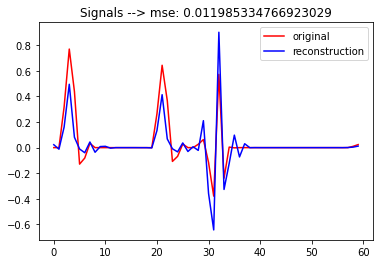

In [659]:
p = model.predict(x)
mse = mean_squared_error(p,x)

plt.plot(np.arange(len(x)), x, c = 'r', label="original")
plt.plot(np.arange(len(p)), p, c = 'b', label="reconstruction")
plt.legend()
plt.title("Signals -->" + " mse: " + str(mse))
print()

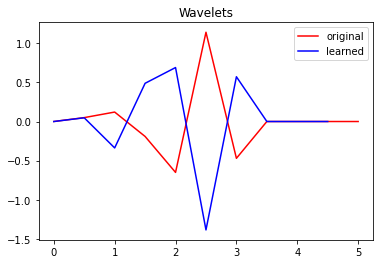

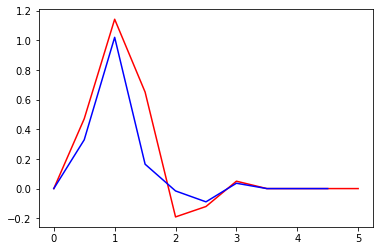

In [665]:
[phi_d,psi_d,phi_r,psi_r,al] = model.wavelet().wavefun(level=1)
[phi, psi, ao] = pywt.Wavelet(w).wavefun(level=1)
lo = np.arange(len(ao))
plt.figure(1)
plt.plot(ao, psi, c = 'r', label="original")
plt.plot(al,psi_d, c='b', label='learned')
plt.title("Wavelets")
plt.legend()

plt.figure(2)
plt.plot(ao, phi, c = 'r', label="original")
plt.plot(al,phi_d, c='b', label='learned')


print()

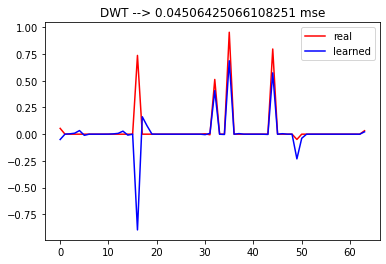

In [666]:

fake_dwt = model.dwt(x)
ca, cd = pywt.dwt(x, wavelet=w)
real_dwt = np.concatenate([cd, ca])

fake_len = len(fake_dwt)
real_len = len(real_dwt)

min_len = min(fake_len, real_len)
real_dwt = real_dwt[:min_len]
fake_dwt = fake_dwt[:min_len]

mse_dwt = mean_squared_error(real_dwt, fake_dwt)
plt.plot(np.arange(min_len), real_dwt, c = 'r', label = 'real')
plt.plot(np.arange(min_len), fake_dwt, c = 'b', label = 'learned')
plt.title("DWT --> " + str(mse_dwt) + " mse")
plt.legend()
print()